<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Objective" data-toc-modified-id="Objective-1">Objective</a></span></li><li><span><a href="#About-Food-101" data-toc-modified-id="About-Food-101-2">About Food-101</a></span></li><li><span><a href="#Train-valid-split" data-toc-modified-id="Train-valid-split-3">Train-valid-split</a></span></li><li><span><a href="#Curating-A-Smaller-Dataset" data-toc-modified-id="Curating-A-Smaller-Dataset-4">Curating A Smaller Dataset</a></span></li><li><span><a href="#Load-Food-101-tiny-Dataset" data-toc-modified-id="Load-Food-101-tiny-Dataset-5">Load Food-101-tiny Dataset</a></span></li><li><span><a href="#Data-Augmentation" data-toc-modified-id="Data-Augmentation-6">Data Augmentation</a></span></li><li><span><a href="#Baseline-Resnet-34-Model" data-toc-modified-id="Baseline-Resnet-34-Model-7">Baseline Resnet-34 Model</a></span><ul class="toc-item"><li><span><a href="#Finding-a-Good-Learning-Rate" data-toc-modified-id="Finding-a-Good-Learning-Rate-7.1">Finding a Good Learning Rate</a></span></li><li><span><a href="#Training-the-Head-Only" data-toc-modified-id="Training-the-Head-Only-7.2">Training the Head Only</a></span></li><li><span><a href="#Training-the-Entire-Network" data-toc-modified-id="Training-the-Entire-Network-7.3">Training the Entire Network</a></span></li><li><span><a href="#Test-Time-Augmentation" data-toc-modified-id="Test-Time-Augmentation-7.4">Test Time Augmentation</a></span></li><li><span><a href="#Post-mortem" data-toc-modified-id="Post-mortem-7.5">Post-mortem</a></span></li></ul></li><li><span><a href="#Going-Deeper:-Resnet-50" data-toc-modified-id="Going-Deeper:-Resnet-50-8">Going Deeper: Resnet-50</a></span></li><li><span><a href="#First-Crack-at-a-Better-Model" data-toc-modified-id="First-Crack-at-a-Better-Model-9">First Crack at a Better Model</a></span><ul class="toc-item"><li><span><a href="#Progressive-Resizing" data-toc-modified-id="Progressive-Resizing-9.1">Progressive Resizing</a></span></li><li><span><a href="#Label-Smoothing" data-toc-modified-id="Label-Smoothing-9.2">Label Smoothing</a></span></li><li><span><a href="#Mixup" data-toc-modified-id="Mixup-9.3">Mixup</a></span></li></ul></li></ul></div>

In [1]:
import numpy as np
import torch

from pathlib import Path
from fastai2.vision.all import *

In [2]:
# Set seed for reproducibility
seed = 9
torch.manual_seed(seed)
np.random.seed(seed)

In [ ]:
# # Although we don't condone it, let's silence warnings for the sake of readability
# import warnings
# warnings.filterwarnings("ignore")

---------

# Objective

The goal of this notebook is to train an image classifier on a small subset of the [Food-101 dataset](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101) using the `fastai2` library. Training on a subset will help us iterate and experiment more quickly. Once we're sure we have the key pieces in place, we'll train on the full dataset in a separate notebook.

--------

# About Food-101

The [Food-101 dataset](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/) consists of 101 classes of food, with $750$ training images and $250$ validation images for each class, for a total of $75,750$ training images and $25,250$ validation images. Classes include foods like `apple pie, bibimbap, crab cakes, gyoza, nachos, and pho`.

All images have been rescaled to have a maximum side length of $512$ pixels and training images have been deliberately left uncleaned (mostly in the form of intense colours and occassionally incorrect labels, according to the authors of the [original paper](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/)). Examining a few images from a handful of classes, we find that $512$ x $384$ (or the transpose) is a common image size. We also find that a non-trivial amount of labels are shockingly incorrect. One of the images labeled "french toast", for example, is an image of an omelette.

-----

# Train-valid-split

We've split the `Food-101` dataset beforehand into Imagenet-style `train/` and `valid/` folders following the `train.txt` and `test.txt` files provided in the dataset's `meta/` directory. This makes loading the data easier as with fastai.

--------

# Curating A Smaller Dataset

To help speed development and prototyping, we'll work initially with a subset of the `Food-101` dataset. We'll select the following ten categories of food to work with: `apple pie, bibimbap, cannoli, edamame, falafel, french toast, ice cream, ramen, sushi, and tiramisu`. We chose a diverse group of categories to make things easier for us, at least in the beginning (admittedly, we also chose some of our favourite foods 😅). 

--------

# Load Food-101-tiny Dataset

Let's load and prep our curated dataset for modeling.

In [3]:
# Prep DataBlock with item & batch transforms
dblock = DataBlock(blocks=(ImageBlock(), CategoryBlock()),
                  get_items=get_image_files,
                  get_y=parent_label,
                  splitter=GrandparentSplitter(),
                  item_tfms=Resize(460),
                  batch_tfms=aug_transforms(size=224, min_scale=0.75))

# Load data
path = Path("../data/food-101-tiny")
dls = dblock.dataloaders(path, bs=64)

In [4]:
# Check for correct number of classes and images
print(dls.train.c, dls.train.n) 
print(dls.valid.c, dls.valid.n)

10 2500
10 840


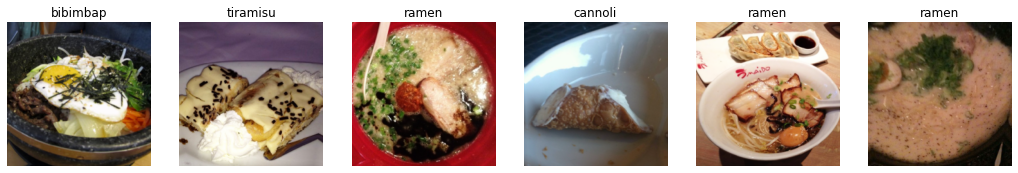

In [6]:
# Check data looks good -- yum, looks good to me!
dls.show_batch(nrows=1, ncols=6)

# Data Augmentation

When we initalised our `DataBlock` above, we had to specify what types of transforms we wanted to use to augument our data. We used the standard transforms specified in `aug_transforms`. By specifying `min_scale=0.75`, we also enabled `RandomResizeCrop`, which is performed on the fly on each batch on the gpu (so won't be shown below). Let's take a closer look at these transforms before we begin training. 

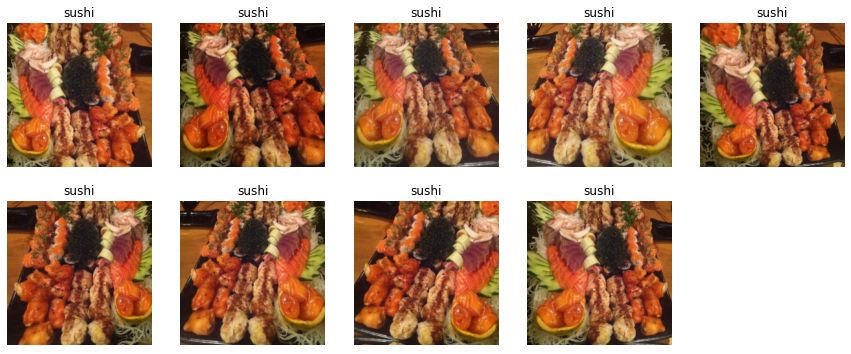

In [7]:
# Nine augmentations for brightness/contrast, rotation, and a flip about the vertical axis
dls.show_batch(nrows=2, unique=True)

---------

# Baseline Resnet-34 Model

Let's start with `Resnet-34` and the default fastai `cnn_learner` parameters as our baseline model. We will

* Start by finding a good initial learning rate for training the head of the model
* Train for a few epochs with all layers frozen except for the head
* Unfreeze all layers and find a good learning rate range to use for all layers
* Train the entire unfrozen network with discriminative learning rates

We'll use `Top-1` accuracy as our validation metric throughout. Note that `cnn_learner` automatically normalizes its data using the stats of the pre-trained model (which will be `ImageNet` stats in our case).

## Finding a Good Learning Rate

Let's start by finding a good base learning rate.

SuggestedLRs(lr_min=0.010000000149011612, lr_steep=0.00363078061491251)

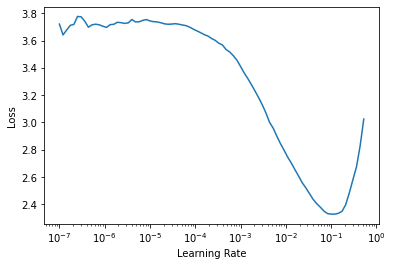

In [8]:
learn = cnn_learner(dls, resnet34, metrics=accuracy)
learn.lr_find()

Looks like the steepest slope is `3e-3`. Let's choose that as our base learning rate and train the head  for a few epochs, keeping the other layers frozen.

## Training the Head Only

Now let's train the head of the network using the learning rate we found above.

In [9]:
learn.fit_one_cycle(3, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,2.292361,0.696219,0.783333,00:31
1,1.425162,0.523507,0.836905,00:29
2,1.027327,0.469701,0.853571,00:29


## Training the Entire Network

Now that we've trained the head for a few epochs, we're ready to unfreeze and train the entire network. But before we train we need to find a good range of learning rates to use. Note that the learning rate plot will be different to the one above, since our model has been trained for a bit.

SuggestedLRs(lr_min=0.0001737800776027143, lr_steep=0.0003311311302240938)

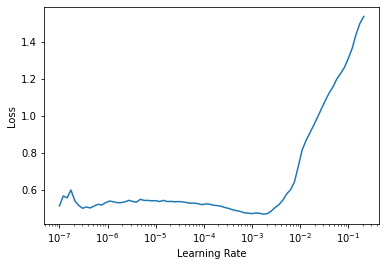

In [10]:
learn.unfreeze()
learn.lr_find()

We're looking for a range well before the loss sharply increases. Looks like `[1e-5, 1e-3]` will do. Now we're ready to train the entire unfrozen network.

In [11]:
learn.fit_one_cycle(5, lr_max=slice(1e-5, 1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.567903,0.432698,0.858333,00:36
1,0.461801,0.405000,0.872619,00:36
2,0.369937,0.355817,0.895238,00:36
3,0.281036,0.351640,0.890476,00:36
4,0.222159,0.345426,0.889286,00:36


## Test Time Augmentation

The last thing we can do to squeeze out a bit of performance is use test time augmentation. We'll use fastai's default `tta()` method, which averages a model's prediction with the predictions from 4 augmented images.

In [12]:
preds, targets = learn.tta()
top_1 = accuracy(preds, targets).item()
top_5 = top_k_accuracy(preds, targets, k=5).item()
print(f"Top-1 Accuracy: {top_1: .4f} | Top-5 Accuracy {top_5: .4f}")

Top-1 Accuracy:  0.9012 | Top-5 Accuracy  0.9964


## Post-mortem

Let's take a closer look at which classes our model had a hard time with.

In [13]:
interp = ClassificationInterpretation.from_learner(learn)
interp.most_confused(min_val=3)

[('apple_pie', 'ice_cream', 8),
 ('french_toast', 'apple_pie', 6),
 ('apple_pie', 'french_toast', 5),
 ('cannoli', 'apple_pie', 5),
 ('apple_pie', 'cannoli', 4),
 ('ramen', 'bibimbap', 4),
 ('apple_pie', 'tiramisu', 3),
 ('cannoli', 'falafel', 3),
 ('cannoli', 'ice_cream', 3),
 ('falafel', 'cannoli', 3),
 ('falafel', 'french_toast', 3),
 ('falafel', 'ice_cream', 3),
 ('ice_cream', 'apple_pie', 3),
 ('sushi', 'french_toast', 3),
 ('tiramisu', 'apple_pie', 3)]

------------

# Going Deeper: Resnet-50

Before we experiment with other techniques for improving our model, let's see a deeper network will give us a quick win.

/home/ubuntu/anaconda3/envs/fastai2/lib/python3.7/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


SuggestedLRs(lr_min=0.005754399299621582, lr_steep=0.0014454397605732083)

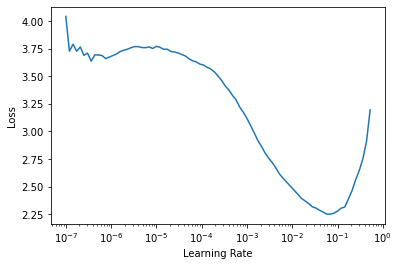

In [4]:
learn = cnn_learner(dls, resnet50, metrics=accuracy)
learn.lr_find()

In [5]:
learn.fit_one_cycle(3, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.712880,0.643770,0.819048,00:54
1,1.034179,0.484055,0.859524,00:52
2,0.702784,0.458725,0.870238,00:52


SuggestedLRs(lr_min=5.754399462603033e-05, lr_steep=6.309573450380412e-07)

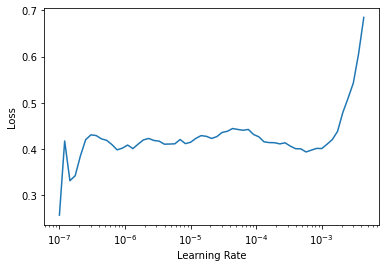

In [6]:
learn.unfreeze()
learn.lr_find()

In [7]:
learn.fit_one_cycle(4, lr_max=slice(1e-5,1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.507529,0.505576,0.853571,01:06
1,0.417704,0.396692,0.884524,01:06
2,0.291661,0.341424,0.905952,01:06
3,0.191407,0.334446,0.909524,01:06


Awesome! A deeper model gave us a quick win. Now let's see if we can't improve things even more.

-----------

# First Crack at a Better Model

Now that we have a solid baseline model, it's time to experiment and see if we can't do a little better! We'll experiment with

* Progressive resizing
* Label smoothing
* Mixup

## Progressive Resizing 

Progressive resizing is the process of gradually using larger and larger images as you train. The key insight behind progressive resizing is the idea that the kinds of features CNNs learn aren't specific to the size of the images it sees. By initially training on smaller images, epochs complete much faster. Finishing training on larger images makes the final accuracy much higher. Progresive resizing also functions as another form of data augmentation and so should help a model generalize.

To implement progressive resizing, we'll define a helper function that returns a set of dataloaders with images of a specified size.

In [6]:
def get_dls(path, bs, size):
    """Return a set of train and valid dataloaders with images of a given size."""
    dblock = DataBlock(blocks=(ImageBlock(), CategoryBlock()),
                  get_items=get_image_files,
                  get_y=parent_label,
                  splitter=GrandparentSplitter(),
                  item_tfms=Resize(460),
                  batch_tfms=aug_transforms(size=size, min_scale=0.75))
    return dblock.dataloaders(path, bs=bs)

In [9]:
# First train on images of size 128
dls = get_dls(path, bs=128, size=128)
learn = cnn_learner(dls, resnet50, metrics=accuracy)
learn.fit_one_cycle(4, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,2.151922,1.180633,0.728571,00:32
1,1.476228,0.827993,0.783333,00:26
2,1.065614,0.685633,0.820238,00:26
3,0.830579,0.632958,0.816667,00:26


In [10]:
# Bump image size to 224
learn.dls = get_dls(path, bs=64, size=224)
learn.fine_tune(5, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.564022,0.426346,0.867857,00:52


epoch,train_loss,valid_loss,accuracy,time
0,0.393765,0.354501,0.894048,01:06
1,0.326764,0.383479,0.879762,01:06
2,0.250055,0.326147,0.903571,01:06
3,0.174571,0.309610,0.910714,01:06
4,0.126224,0.304700,0.914286,01:06


In [8]:
# Let's try one last bump to the max image dim in our dataset
learn.dls = get_dls(path, bs=24, size=512)
learn.fine_tune(5, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.608257,0.424526,0.863095,03:44


epoch,train_loss,valid_loss,accuracy,time
0,0.433789,0.333594,0.895238,04:43
1,0.326149,0.317608,0.904762,04:41
2,0.235837,0.293494,0.911905,04:41
3,0.146429,0.265351,0.921429,04:41
4,0.117052,0.252202,0.934524,04:41


## Label Smoothing

Our classifier is trained to return a probaility of `1.0` for the correct class and `0.0` for all other classes. However, it can never in fact predict `1.0` on the nose. This means that even a model that predicts the correct class with `0.999` probability will still affect the loss and hence the gradients. In other words, our model will continue to minimize the loss by becoming more and more confident in its predictions even when it's correct, because that's what it's trained to do.

Label smoothing tempers our model's confidence by changing the labels of our data from `(0, 1)` to something like `(0.1, 0.9)`. This makes it possible for a model to achieve zero loss on a specific training example, meaning that the training example will no longer affect the loss and gradients, which helps mitigate overfitting. The final loss will almost always be higher compared with using normal cross entropy because our model's predictions are bounded to the region to the interval `(0.1, 0.9)`. In practice, label smoothing requires more epochs to train but often improves a model's ability to generalize.

Because we had such tremendous success with progressive re-sizing, we'll implement label smoothing alongside it. Since our loss function is slightly different, we'll first need to find a good base learning rate.

SuggestedLRs(lr_min=0.010000000149011612, lr_steep=0.0004786300996784121)

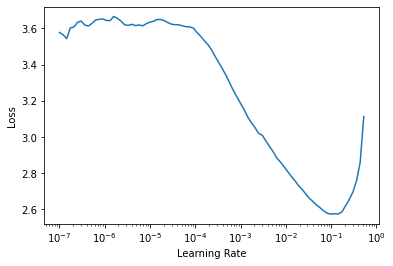

In [10]:
# First find a good learning rate
dls = get_dls(path, bs=128, size=128)
learn = cnn_learner(dls, resnet50, loss_func=LabelSmoothingCrossEntropy(), metrics=accuracy)
learn.lr_find()

In [9]:
# Train on images of size 128
dls = get_dls(path, bs=128, size=128)
learn = cnn_learner(dls, resnet50, loss_func=LabelSmoothingCrossEntropy(), metrics=accuracy)
learn.fit_one_cycle(4, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,2.419918,1.910604,0.719048,00:26
1,1.971646,1.423815,0.740476,00:26
2,1.634061,1.132888,0.813095,00:26
3,1.421472,1.073061,0.808333,00:26


In [12]:
# Unfreeze and train with image size 128
learn.unfreeze()
learn.fit_one_cycle(4, lr_max=slice(1e-5, 1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,1.098193,1.044757,0.815476,00:30
1,1.052123,1.013094,0.841667,00:30
2,0.982605,0.982198,0.850000,00:30
3,0.923970,0.967240,0.848810,00:30


In [13]:
# Freeze and train with image size 224
learn.freeze()
learn.dls = get_dls(path, bs=64, size=224)
learn.fit_one_cycle(4, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.953199,0.977781,0.857143,00:58
1,0.959214,0.948277,0.842857,00:53
2,0.880888,0.809827,0.900000,00:53
3,0.800068,0.801735,0.914286,00:53


In [15]:
# Unfreeze and train with image size 224
learn.unfreeze()
learn.fit_one_cycle(4, lr_max=slice(1e-5, 1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.743417,0.830688,0.894048,01:06
1,0.740392,0.786748,0.907143,01:06
2,0.695581,0.753720,0.914286,01:06
3,0.657030,0.745201,0.916667,01:06


In [16]:
# Freeze and train with image size 512
learn.freeze()
learn.dls = get_dls(path, bs=24, size=512)
learn.fit_one_cycle(4, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.897090,1.029452,0.816667,03:44
1,0.951080,0.910952,0.855952,03:38
2,0.822892,0.771880,0.920238,03:38
3,0.730569,0.756830,0.915476,03:39


In [17]:
# Unfreeze and train with image size 512
learn.unfreeze()
learn.fit_one_cycle(6, lr_max=slice(1e-5, 1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.733788,0.799930,0.908333,04:43
1,0.808346,0.889051,0.870238,04:40
2,0.747505,0.767665,0.917857,04:40
3,0.672190,0.727929,0.925000,04:40
4,0.624601,0.705921,0.930952,04:40
5,0.605379,0.697938,0.935714,04:40


## Mixup